## Read in Play by Play Data

In [1]:
import pandas as pd
import os
import numpy as np
import re

In [2]:
path = "/Users/brennan/Data/baseball/"

In [3]:
files = [path + file for file in os.listdir(path) if re.match(".*BEV", file)]
files.sort()

In [4]:
col_names = ["game", "visitors", "inning", "batting_team", "outs", "balls",
             "strikes", "seq", "v_score", "h_score", "b_id", "b_hand", "p_id",
             "p_hand", "runner1_id", "runner2_id", "runner3_id", "desc",
             "leadoff", "pinchhit", "position", "lineup_no", "event_type",
             "batter_event", "ab", "hit_value", "sac_hit", "sac_fly",
             "out_play", "rbi", "wild_ptich", "passed_ball", "errors",
             "batter_dest", "runner1_dest", "runner2_dest", "runner3_dest"]

In [5]:
pbp = pd.concat([pd.read_csv(file, names = col_names, true_values = ["T"], false_values = ["F"]) for file in files])

In [6]:
pbp["home"] = pbp["game"].str[:3]
pbp["id"] = pbp["game"].str[3:]
pbp["runner1"] = ~pbp["runner1_id"].isna()
pbp["runner2"] = ~pbp["runner2_id"].isna()
pbp["runner3"] = ~pbp["runner3_id"].isna()
pbp["score"] = pbp["batting_team"] * pbp["h_score"] + (1 - pbp["batting_team"]) * pbp["v_score"]

In [7]:
pbp["runner000"] = ~(pbp["runner1"] | pbp["runner2"] | pbp["runner3"])
pbp["runner100"] = pbp["runner1"] & ~(pbp["runner2"] | pbp["runner3"])
pbp["runner020"] = pbp["runner2"] & ~(pbp["runner1"] | pbp["runner3"])
pbp["runner120"] = pbp["runner1"] & pbp["runner2"] & ~pbp["runner3"]
pbp["runner003"] = pbp["runner3"] & ~(pbp["runner1"] | pbp["runner2"])
pbp["runner103"] = pbp["runner1"] & pbp["runner3"] & ~pbp["runner2"]
pbp["runner023"] = pbp["runner2"] & pbp["runner3"] & ~pbp["runner1"]
pbp["runner123"] = pbp["runner1"] & pbp["runner2"] & pbp["runner3"]

In [10]:
pbp.runner1_dest.unique()

array([0, 2, 1, 4, 3, 5, 6])

### Calculate On Base Percentage

In [8]:
obp_data = pbp[["ab", "hit_value", "sac_hit", "sac_fly", "event_type"]]

In [9]:
ab = obp_data["ab"].sum()

In [10]:
H = (obp_data["hit_value"] > 0).sum()

In [11]:
H / ab

0.24271250726455204

In [12]:
event_map = {2: "out", 3: "K", 4: "SB", 5: "Def. Ind.", 6: "CS", 7: "Pick Err.",
             8: "Pickoff", 9: "WP", 10: "PB", 11: "BALK", 12: "Adv.", 
             13: "F. err.", 14: "BB", 15: "IBB", 16: "HBP", 17: "Interference",
             18: "E", 19: "FC", 20: "1B", 21: "2B", 22: "3B", 23: "HR"}

In [13]:
obp_events = obp_data["event_type"].value_counts()
obp_events.index = obp_events.index.map(event_map)

In [14]:
obp_events.index.unique()

Index(['out', 'K', '1B', 'BB', '2B', 'HR', 'SB', 'HBP', 'WP', 'E', 'FC', '3B',
       'CS', 'IBB', 'Pickoff', 'Def. Ind.', 'PB', 'BALK', 'Adv.',
       'Interference', 'F. err.'],
      dtype='object')

In [15]:
num = obp_events[["1B", "2B", "3B", "HR", "BB", "HBP"]].sum()

In [16]:
denom = ab + obp_events[["BB", "HBP"]].sum() #+ obp_data.sac_fly.sum() 

In [17]:
obp = num / denom

### Calculate wOBA

In [18]:
pbp = pbp[["id", "home", "visitors", "inning", "batting_team", "outs", "b_id",
           "p_id", "event_type", "batter_event", "sac_hit", "sac_fly",
           "errors", "out_play", "rbi", "runner000", "runner100", "runner020", 
           "runner120","runner003", "runner103", "runner023", "runner123", "score"]]

In [19]:
batting = pbp.loc[pbp["batter_event"]]

In [20]:
run_exp_cols = ["id", "home", "visitors", "inning", "batting_team"]

In [21]:
max_scores = batting.groupby(run_exp_cols)[["score"]].max()
max_scores.columns = ["max_runs"]

In [22]:
batting = batting.set_index(run_exp_cols).join(max_scores, how = "left").reset_index()

In [23]:
batting["fwd_runs"] = batting["max_runs"] - batting["score"]

In [24]:
def calc_run_exp(runner):
    return batting.loc[batting[runner]].groupby("outs")["fwd_runs"].mean()

In [25]:
runners = batting.columns[batting.columns.str.startswith("runner")]

In [26]:
re24 = pd.concat({runner: calc_run_exp(runner) for runner in runners}, axis = 1)
re24

,runner000,runner100,runner020,runner120,runner003,runner103,runner023,runner123
outs,,,,,,,,
0,0.467744,0.848654,1.010277,1.396901,1.238462,1.700115,1.947950,2.299248
1,0.249442,0.496782,0.649254,0.877859,0.928941,1.099465,1.365691,1.462416
2,0.095093,0.201814,0.298542,0.421255,0.364076,0.484707,0.520642,0.735498


In [27]:
batting = batting.loc[batting["batter_event"]]

In [28]:
batting["bases"] = batting[runners].idxmax(axis = 1)

In [29]:
x = batting["bases"].iloc[1:].reset_index(drop = True)

In [30]:
batting["outcome"] = pd.concat([x, pd.Series("runner000", index = [x.index.max() + 1])])

In [31]:
batting["after_outs"] = batting["outs"] + batting["out_play"]

In [32]:
def calc_re(x):
    before = re24.loc[x["outs"], x["bases"]]
    if x["after_outs"] == 3:
        after = 0
    else:
        after = re24.loc[x["after_outs"], x["outcome"]]
    return after - before + x["rbi"]

In [33]:
batting["re"] = batting.apply(calc_re, axis = 1)

In [34]:
base_factor = batting.groupby("event_type")["re"].mean()

In [35]:
base_factor.index = base_factor.index.map(lambda x: event_map[x])

In [36]:
out_level = batting.loc[batting["event_type"].isin([2, 3]), "re"].mean()

In [37]:
out_scaled_factor = base_factor - out_level

In [38]:
out_scaled_factor

event_type
out            -0.000076
K               0.000155
BB              0.559463
IBB             0.427871
HBP             0.588171
Interference    0.616266
E               0.545613
FC              0.286945
1B              0.693079
2B              0.988234
3B              1.232139
HR              1.662953
Name: re, dtype: float64

In [39]:
woba_events = ["BB", "HBP", "1B", "2B", "3B", "HR"]

In [40]:
batting["events"] = batting["event_type"].map(event_map)

In [41]:
hit_events = batting["events"].value_counts()[woba_events]

In [42]:
league_woba_unscaled = (hit_events * out_scaled_factor[woba_events]).sum() / batting.shape[0]

In [43]:
league_woba_unscaled

0.24439886369075467

In [44]:
woba_scale = obp / league_woba_unscaled

In [45]:
woba_scale

1.2760019257501667

In [46]:
linear_factor = out_scaled_factor * woba_scale

In [47]:
linear_factor[woba_events]

event_type
BB     0.713876
HBP    0.750507
1B     0.884370
2B     1.260988
3B     1.572211
HR     2.121931
Name: re, dtype: float64

In [48]:
def calc_woba_by_batter(playid):
    id_events = batting.loc[batting.b_id == playid, "events"].value_counts()
    id_events = id_events[id_events.index.isin(woba_events)]
    num = (id_events * linear_factor[id_events.index]).sum()
    #num = (batting.loc[batting.b_id == playid, "events"].value_counts()[woba_factors] * linear_factor[woba_factors]).sum()
    denom = batting.loc[batting.b_id == playid, "events"].shape[0]
    return num / denom

In [49]:
batter_woba = pd.Series({playid: calc_woba_by_batter(playid) for playid in batting.b_id.unique()})

In [50]:
def pa_by_batter(playid):
    id_events = batting.loc[batting.b_id == playid, "events"].value_counts()
    return id_events.sum()

In [51]:
batter_pa = pd.Series({playid: pa_by_batter(playid) for playid in batting.b_id.unique()})

In [52]:
batter_woba[["mullc002", "rutsa001", "mounr001", "santa003", "uriar001", "matej003", "haysa001", "vavrt001", "stowk001"]]

mullc002    0.315966
rutsa001    0.358900
mounr001    0.319165
santa003    0.340382
uriar001    0.314120
matej003    0.280942
haysa001    0.317252
vavrt001    0.306657
stowk001    0.319570
dtype: float64

In [53]:
def calc_woba_by_pitcher(playid):
    id_events = batting.loc[batting.p_id == playid, "events"].value_counts()
    id_events = id_events[id_events.index.isin(woba_events)]
    num = (id_events * linear_factor[id_events.index]).sum()
    denom = batting.loc[batting.p_id == playid, "events"].shape[0]
    return num / denom

In [54]:
pitcher_wobaa = pd.Series({playid: calc_woba_by_pitcher(playid) for playid in batting.p_id.unique()})

In [55]:
pitcher_wobaa[["watks003", "votha001", "kremd001", "lylej001", "bradk001", "perec004", "bautf001", "wellt003"]]

watks003    0.334150
votha001    0.334347
kremd001    0.313640
lylej001    0.344510
bradk001    0.336247
perec004    0.258307
bautf001    0.242534
wellt003    0.303430
dtype: float64

In [56]:
batter_woba = pd.concat({"PA": batter_pa, "wOBA": batter_woba}, axis = 1)

### wRAA

In [57]:
league_woba_scaled = league_woba_unscaled * woba_scale

In [58]:
batter_wraa = (batter_woba["wOBA"] - league_woba_scaled) / woba_scale * batter_woba["PA"]

In [60]:
batter_wraa = pd.concat({"PA": batter_pa, "wRAA": batter_wraa}, axis = 1)

### wRC and wRC+

In [61]:
batter_woba["wOBA"].mean()

0.2797911510108576

In [62]:
league_runs = batting.groupby(["id", "home", "visitors", "batting_team"])["score"].max().sum()
league_pa = batting.shape[0]
league_rpa = league_runs / league_pa

In [63]:
league_rpa

0.11261068266209655

In [135]:
league_woba_scaled

0.31185342072055544

In [140]:
batter_woba

,PA,wOBA
altuj001,604,0.401098
branm003,277,0.344791
brega001,656,0.362812
alvay001,561,0.426376
gurry001,584,0.287023
...,...,...
naylb001,8,0.000000
davib006,11,0.225692
okeeb001,4,0.399561
lopeo001,10,0.602010


In [141]:
woba_scale

1.2760019257501667

In [209]:
wRC = (batter_wraa["wRAA"] / batter_wraa["PA"] + league_rpa)* batter_woba["PA"]

In [75]:
park_factors = pd.read_csv(path + "statcast_parkfactors.csv", usecols = ["Team", "Park Factor"], index_col = 0)

In [240]:
park_factors

,Park Factor
Team,
COL,115
CIN,109
BOS,107
LAN,104
PHI,104
ANA,103
MIA,103
KCA,102
SFN,102


In [88]:
team_to_retrosheet = {"Rockies": "COL", "Reds": "CIN", "Red Sox": "BOS",
                      "Dodgers": "LAN", "Phillies": "PHI", "Angels": "ANA",
                      "Marlins": "MIA", "Royals": "KCA", "Giants": "SFN",
                      "Rangers": "TEX", "White Sox": "CHA", "Astros": "HOU",
                      "Blue Jays": "TOR", "Cubs": "CHN", "Pirates": "PIT",
                      "Braves": "ATL", "Nationals": "WAS", "Twins": "MIN",
                      "Yankees": "NYA", "Rays": "TBA", "D-backs": "ARI", 
                      "Brewers": "MIL", "Tigers": "DET", "Orioles": "BAL",
                      "Cardinals": "SLN", "Guardians": "CLE", "Athletics": "OAK",
                      "Mets": "NYN", "Padres": "SDN", "Mariners": "SEA"}

In [90]:
park_factors.index = park_factors.index.map(team_to_retrosheet)

In [103]:
player_team_map = batting.groupby("b_id")["home"].value_counts().groupby(level = 0).idxmax().apply(lambda x: x[1])

In [113]:
batter_wraa["PF"] = park_factors.loc[batter_wraa.index.map(player_team_map)].values

In [220]:
unscaled_wRCplus = (batter_wraa["wRAA"] / batter_wraa["PA"] - (batter_wraa["PF"] / 100 * league_rpa) + 2 * league_rpa) / (wRC.sum() / batting.shape[0]) * 100

In [223]:
wRCplus_scale = 100 / unscaled_wRCplus.mean()

In [224]:
wRCplus = unscaled_wRCplus * wRCplus_scale

In [232]:
wRCplus.max()

798.5130467031194

In [233]:
wRCplus["judga001"]

255.60354279120733

<AxesSubplot: >

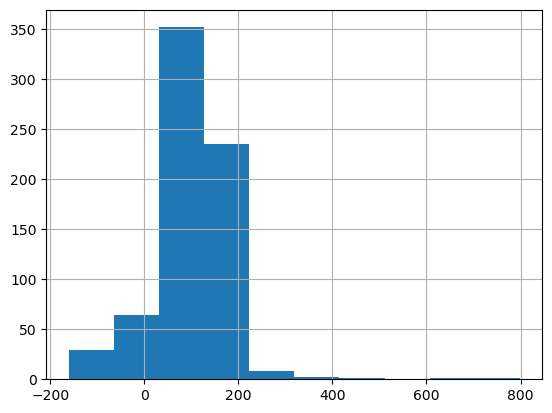

In [227]:
wRCplus.hist()